<a href="https://colab.research.google.com/github/realyou0312/DataAnalysis/blob/main/3_Movie_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 영화 추천 시스템 



# PROBLEM STATEMENT

- 추천시스템은 영화나 노래등을 추천하는데 사용되며, 주로 관심사나 이용 내역을 기반으로 추천한다.
- 이 노트북에서는, Item-based Collaborative Filtering 으로 추천시스템을 구현한다.

- Dataset MovieLens: https://grouplens.org/datasets/movielens/100k/ 


# STEP #0: LIBRARIES IMPORT


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/보충수업')

# STEP #1: IMPORT DATASET

### Movie_Id_Titles.csv 파일을 읽으세요.

In [ ]:
movie_titles_df = pd.read_csv('Movie_Id_Titles.csv')

In [ ]:
movie_titles_df

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


### 'u.data.data' 파일을 구글드라이브에서 열어보세요.

그러면, 탭으로 구분되어 있고, 맨 위에 컬럼이름이 없습니다.

따라서 컬럼이름을 'user_id', 'item_id', 'rating', 'timestamp' 로 지어주면서 데이터프레임으로 읽어오세요.

In [ ]:
movies_rating_df = pd.read_csv('u.data.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [ ]:
movies_rating_df

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
...,...,...,...,...
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156


### timestamp 컬럼은 필요없으니, movies_rating_df 에서 아예 제거하시오.

In [ ]:
movies_rating_df.drop('timestamp', axis=1, inplace=True)

In [ ]:
movies_rating_df

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3
...,...,...,...
99998,880,476,3
99999,716,204,5
100000,276,1090,1
100001,13,225,2


### 두개의 데이터프레임을 합치시오.

### 어떻게 합칠지 모양을 잘 보고 합칩니다.

In [ ]:
movies_rating_df.describe()

,user_id,item_id,rating
count,100003.000000,100003.000000,100003.000000
mean,462.470876,425.520914,3.529864
std,266.622454,330.797791,1.125704
min,0.000000,1.000000,1.000000
25%,254.000000,175.000000,3.000000
50%,447.000000,322.000000,4.000000
75%,682.000000,631.000000,4.000000
max,943.000000,1682.000000,5.000000


In [ ]:
movies_rating_df['user_id'].nunique()

944

In [ ]:
merge = pd.merge(movies_rating_df, movie_titles_df, on='item_id')

# STEP #2: VISUALIZE DATASET

### 각 영화 제목별로, 별점에 대한 기본통계치(최대,최소,중앙,표준편차,1/4,3/4 값)를 보여주세요.

In [ ]:
merge.groupby('title')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.0,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.0,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.0,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.0,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.0,2.772727,1.008421,1.0,2.00,3.0,3.0,5.0
"Young Poisoner's Handbook, The (1995)",41.0,3.341463,1.237129,1.0,3.00,4.0,4.0,5.0
Zeus and Roxanne (1997),6.0,2.166667,0.983192,1.0,1.25,2.5,3.0,3.0


### 각 영화별 별점의 평균을 구하고, 이를 ratings_df_mean 에 저장하시오.

In [ ]:
ratings_df_mean = merge.groupby('title')['rating'].mean()

### 각 영화별로, 몇개의 데이터가 있는지 구하고, 이를 ratings_df_count 에 저장하시오.

In [ ]:
ratings_df_count = merge.groupby('title')['rating'].count()

### 두 데이터프레임을 합치세요. 

In [ ]:
ratings_mean_count_df = pd.merge(ratings_df_count, ratings_df_mean, on='title')

### 컬럼명을 확인하면, 합쳐진 컬럼들이 rating, rating 이라고 되어있습니다. 이를 count, mean 으로 컬럼명을 셋팅하세요.

In [ ]:
ratings_mean_count_df.columns = ['count', 'mean']

### mean 으로 히스토그램을 그려보세요.

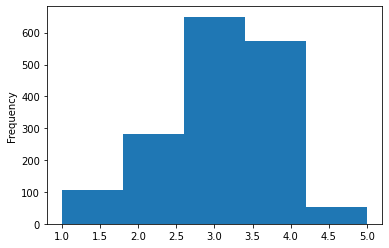

In [ ]:
ratings_mean_count_df['mean'].plot(kind = 'hist', bins=5)
plt.show()

### count 로 히스토그램을 그려보세요.

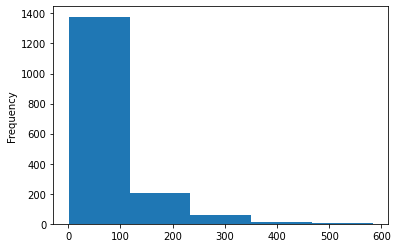

In [ ]:
ratings_mean_count_df['count'].plot(kind = 'hist', bins=5)
plt.show()

### 평균점수가 5점인 영화들은 어떤 영화인지 확인하세요.

In [ ]:
ratings_mean_count_df['mean']==5

title
'Til There Was You (1997)                False
1-900 (1994)                             False
101 Dalmatians (1996)                    False
12 Angry Men (1957)                      False
187 (1997)                               False
                                         ...  
Young Guns II (1990)                     False
Young Poisoner's Handbook, The (1995)    False
Zeus and Roxanne (1997)                  False
unknown                                  False
Á köldum klaka (Cold Fever) (1994)       False
Name: mean, Length: 1664, dtype: bool

In [ ]:
ratings_mean_count_df.loc[ratings_mean_count_df['mean']==5]

,count,mean
title,,
Aiqing wansui (1994),1,5.0
Entertaining Angels: The Dorothy Day Story (1996),1,5.0
"Great Day in Harlem, A (1994)",1,5.0
Marlene Dietrich: Shadow and Light (1996),1,5.0
Prefontaine (1997),3,5.0
"Saint of Fort Washington, The (1993)",2,5.0
Santa with Muscles (1996),2,5.0
Someone Else's America (1995),1,5.0
Star Kid (1997),3,5.0


### count 가 가장 많은 것부터 정렬하여 100개까지만 보여주세요.

In [ ]:
ratings_mean_count_df.sort_values(by='count', ascending=False).head(100).index

Index(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)',
       'Raiders of the Lost Ark (1981)', 'Godfather, The (1972)',
       'Pulp Fiction (1994)', 'Twelve Monkeys (1995)',
       'Silence of the Lambs, The (1991)', 'Jerry Maguire (1996)',
       'Chasing Amy (1997)', 'Rock, The (1996)',
       'Empire Strikes Back, The (1980)', 'Star Trek: First Contact (1996)',
       'Titanic (1997)', 'Back to the Future (1985)',
       'Mission: Impossible (1996)', 'Fugitive, The (1993)',
       'Indiana Jones and the Last Crusade (1989)',
       'Willy Wonka and the Chocolate Factory (1971)',
       'Princess Bride, The (1987)', 'Forrest Gump (1994)',
       'Saint, The (1997)', 'Monty Python and the Holy Grail (1974)',
       'Full Monty, The (1997)', 'Men in Black (1997)',
       'Terminator, Th

# STEP #3: 영화 하나에 대한, ITEM-BASED COLLABORATIVE FILTERING 수행!

In [ ]:
# movies_rating_df 를 가지고 아래 피봇테이블 합니다.

### 피봇 테이블을 하여, 콜라보레이티브 필터링 포맷으로 변경

In [ ]:
movies_rating_df # 컬럼은 아이템 이름, 인덱스는 유저 이름이 나와야 함

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3
...,...,...,...
99998,880,476,3
99999,716,204,5
100000,276,1090,1
100001,13,225,2


In [ ]:
userid_movietitle_matrix = merge.pivot_table(index='user_id', columns='title', values='rating')

In [ ]:
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
userid_movietitle_matrix.loc[23, 'Star Wars (1977)']

4.0

### 전체 영화와, 타이타닉 영화의 상관관계 분석을 하면, 타이타닉을 본 사람들에게 상관계수가 높은 영화를 추천하면 된다. corrwith 함수를 이용한다.

In [ ]:
userid_movietitle_matrix['Titanic (1997)']

user_id
0      NaN
1      NaN
2      5.0
3      NaN
4      NaN
      ... 
939    NaN
940    5.0
941    NaN
942    3.0
943    NaN
Name: Titanic (1997), Length: 944, dtype: float64

In [ ]:
titanic_series = userid_movietitle_matrix.corrwith(userid_movietitle_matrix['Titanic (1997)'])

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [ ]:
titanic_series.sort_values(ascending=False)

title
Hearts and Minds (1996)               1.0
Titanic (1997)                        1.0
Pest, The (1997)                      1.0
Newton Boys, The (1998)               1.0
Simple Wish, A (1997)                 1.0
                                     ... 
Yankee Zulu (1994)                    NaN
You So Crazy (1994)                   NaN
Zeus and Roxanne (1997)               NaN
unknown                               NaN
Á köldum klaka (Cold Fever) (1994)    NaN
Length: 1664, dtype: float64

In [ ]:
titanic_correlations = pd.DataFrame(titanic_series, columns=['Correlation'])

In [ ]:
titanic_correlations

,Correlation
title,
'Til There Was You (1997),-0.062017
1-900 (1994),NaN
101 Dalmatians (1996),0.120113
12 Angry Men (1957),0.077700
187 (1997),0.315654
...,...
Young Guns II (1990),0.317274
"Young Poisoner's Handbook, The (1995)",0.356783
Zeus and Roxanne (1997),NaN


In [ ]:
titanic_correlations = titanic_correlations.join(ratings_mean_count_df['count'])

In [ ]:
titanic_correlations.dropna(inplace=True)

In [ ]:
titanic_correlations.sort_values('Correlation', ascending=False)

,Correlation,count
title,,
Nadja (1994),1.0,8
"Pest, The (1997)",1.0,8
"Savage Nights (Nuits fauves, Les) (1992)",1.0,3
For Ever Mozart (1996),1.0,3
"Jerky Boys, The (1994)",1.0,3
...,...,...
Pather Panchali (1955),-1.0,8
Angel Baby (1995),-1.0,4
Blood Beach (1981),-1.0,6


In [ ]:
#영화본사람이 적어도 80명 이상인 사람들
titanic_correlations.loc[ titanic_correlations['count']>=80 ].sort_values('Correlation', ascending=False)

,Correlation,count
title,,
Titanic (1997),1.000000,350
"River Wild, The (1994)",0.497600,146
"Abyss, The (1989)",0.472103,151
Bram Stoker's Dracula (1992),0.443560,120
True Lies (1994),0.435104,208
...,...,...
Brazil (1985),-0.243532,208
Richard III (1995),-0.275451,89
Cold Comfort Farm (1995),-0.307150,125


### 실습. star wars 를 본 사람들에게 영화를 추천할 것입니다. 5개의 추천 영화 제목을 찾으세요.

힌트 : 먼저 star wars 의 정확한 이름을 검색해서 찾으세요. 그리고 나서 스타워즈를 본 유저의 데이터를 가져와서, 위와 같이 상관관계분석을 합니다.

# STEP#4: 전체 데이터셋에 대한 ITEM-BASED COLLABORATIVE FILTER 를 만들자!

In [ ]:
userid_movietitle_matrix.corr()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),1.0,NaN,-1.000000,-0.500000,-0.500000,0.522233,NaN,-0.426401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981981,0.866025,NaN,NaN,0.571772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.867722,NaN,NaN,NaN,-0.034483,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,-0.132453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,1.0,NaN,NaN,NaN,NaN,NaN,-0.981981,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981981,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.188982,NaN,NaN,0.995871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.944911,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),-1.0,NaN,1.000000,-0.049890,0.269191,0.048973,0.266928,-0.043407,NaN,0.111111,0.522233,NaN,1.0,NaN,NaN,0.398783,0.236350,-0.147491,0.094964,NaN,0.195058,-0.094832,NaN,0.242363,-0.135467,-0.263889,0.000000,0.192703,NaN,0.531490,NaN,NaN,0.221943,0.750000,-0.645497,0.132116,0.385118,0.326669,0.883883,-0.5,...,NaN,0.000000,NaN,NaN,NaN,-0.219265,NaN,0.0,0.257404,0.105261,NaN,NaN,0.575224,0.880705,-0.101371,1.0,1.000000,0.714832,1.000000,NaN,0.366592,0.219445,NaN,0.969458,NaN,-1.000000,NaN,NaN,-0.002382,0.042025,NaN,-1.000000,NaN,0.158840,0.119234,0.680414,0.000000,0.707107,NaN,NaN
12 Angry Men (1957),-0.5,NaN,-0.049890,1.000000,0.666667,0.256625,0.274772,0.178848,NaN,0.457176,0.635698,NaN,NaN,NaN,1.0,-0.163455,0.045374,-0.243775,-0.045596,1.0,0.000000,0.867722,NaN,0.020207,0.343750,0.450000,0.794719,0.266966,1.000000,0.420304,NaN,-0.097129,0.228031,0.000000,0.042640,0.651377,0.030291,-0.226871,NaN,NaN,...,-0.5,0.677908,NaN,NaN,0.707107,0.264693,NaN,0.0,0.265786,0.149164

In [ ]:
movie_correlations = userid_movietitle_matrix.corr(min_periods=80) #중요 - 80개 이상의 rating이 있는 것만으로 correlation

In [ ]:
movie_correlations

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.178848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### 나의 별점 정보를 가지고, 영화를 추천해 달라고 할 것이다! 

내 영화 별점 정보는 My_Ratings.csv 파일에 있다. 

In [ ]:
myRatings = pd.read_csv('My_Ratings.csv')
 

In [ ]:
myRatings

,Movie Name,Ratings
0,Liar Liar (1997),5
1,Star Wars (1977),1
2,Dirty Dancing (1987),4


In [ ]:
similar_movies_list = pd.DataFrame()

for i in np.arange(0, len(myRatings)):
  movie_title = myRatings['Movie Name'][i]
  similar_movie = movie_correlations[movie_title].dropna().sort_values(ascending=False)
  similar_movie.columns = ['Correlation']
  similar_movie['Weight'] = similar_movie['Correlation'] * myRatings['Ratings'][i]
  similar_movies_list = similar_movies_list.append(similar_movie)

In [ ]:
similar_movies_list.sort_values('Weight', ascending=False).head(7)

NameError: ignored

In [ ]:
movie_correlations.to_csv('movie_correlations.csv')

## 이제는 두번째 영화인, 스타워즈도 추천영화 똑같이 가져오자.

## 위의 추천영화 작업을 자동화 하기 위한 파이프라인을 만드시오. 

힌트 : 반복문을 사용하여 비슷한영화에 대한 데이터프레임을 만들고, 이를 아래 빈 데이터프레임에 계속하여 추가하시오. 반복문이 끝나면, 아래 데이터프레임을 wegiht 컬럼으로 정렬하면 됩니다.

In [ ]:
similar_movies_list = pd.DataFrame()